In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

import load_data as load
from models.model import Model
from models.customlayers import *
from models.activations import *
from training import *

import moviepy.editor as mpe
from models.AELSTM import *
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Insight/video-representations/frames')

# AE (No LSTM)

In [3]:
# check no-lstm AE

training_epochs = 10
batchsize = 4
sequence_length = 64

model = Model(encoder, lstm_cell, decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, training_epochs)

encoded, decoded = model.build_encoder_decoder(training_inputs, reuse=False)    # discard decoder here
loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))

optimizer = tf.train.AdamOptimizer()
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)    # clip those uglies
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, decoded_validation = model.build_encoder_decoder(validation_inputs, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    validation_predictions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, pred, input_recover = sesh.run(
                [train_step, loss, encoded, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                print(step, loss_value)
                encodings.append(enc)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, enc, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'AE')

0 18395.7
250 2564.11
500 3242.64
750 3391.53
1000 2582.93
1250 2199.7
1500 2999.76
1750 2045.3
2000 1980.87
2250 1955.5
2500 1218.12
2750 2290.34
3000 1623.59
3250 2307.66
3500 1456.5
3750 1416.06
4000 1472.05
4250 2001.29
4500 1437.61
4750 1440.82
5000 1264.55
5250 806.73
10750 1270.73
11000 992.628
11250 1167.76
11500 1095.96
11750 1232.92
12000 1780.24
12250 1051.15
12500 1373.36
12750 1192.05
13000 952.715
13250 849.52
13500 1536.87
13750 1259.69
14000 1132.28
14250 941.448
14500 942.736
14750 1127.5
15000 910.377
15250 1161.34
15500 783.207
15750 1119.67
16000 1006.77
16250 865.525
16500 924.024
16750 754.463
17000 1425.89
17250 1238.67
17500 1046.12
17750 801.224
18000 904.887
18250 256.347
18500 799.152
18750 573.388
19000 840.353
19250 1008.23
19500 611.041
19750 538.696
20000 878.167
20250 842.885
20500 805.694
20750 721.415
21000 910.426
21250 441.957
21500 771.854
21750 1144.59
22000 831.27
22250 776.604
22500 967.606
22750 1070.97
23000 1009.51
23250 794.169
23500 712.002


# LSTM-AE

In [3]:
training_epochs = 10
batchsize = 4
sequence_length = 64

model = Model(encoder, lstm_cell, tied_decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, training_epochs)

encoded, transitioned, decoded = model.build(training_inputs)    # discard decoder here
loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))

# decoded_ = model.build_encoder_decoder(encoded, reuse=True)
    
# encoded_loss = tf.reduce_mean(tf.pow(decoded_ - training_inputs, 2))

# loss = transitioned_loss + encoded_loss

optimizer = tf.train.AdamOptimizer()
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)    # clip those uglies
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, transitioned_validation, decoded_validation = model.build(validation_inputs, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

encoder/Reshape:0
[5, 5, 32, 64] [256, 48, 68, 64]
[5, 5, 32, 32] [256, 52, 72, 32]
[3, 3, 16, 32] [256, 56, 76, 32]
[3, 3, 3, 16] [256, 58, 78, 16]
encoder_2/Reshape:0
[5, 5, 32, 64] [256, 48, 68, 64]
[5, 5, 32, 32] [256, 52, 72, 32]
[3, 3, 16, 32] [256, 56, 76, 32]
[3, 3, 3, 16] [256, 58, 78, 16]


In [5]:
np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]) / 1000000

220.70499799999999

In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    transitions = []
    validation_predictions = []
    validation_transitions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, trans, pred, input_recover = sesh.run(
                [train_step, loss, encoded, transitioned, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                print(step, loss_value)
                encodings.append(enc)
                transitions.append(trans)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, enc, trans, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, transitioned_validation, 
                 decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_transitions.append(trans)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm-tied-relu')
    

0 18543.9
250 3947.64
500 3516.28
750 3002.4
1000 2474.34
1250 1864.75
1500 2147.64


[0, 2000]

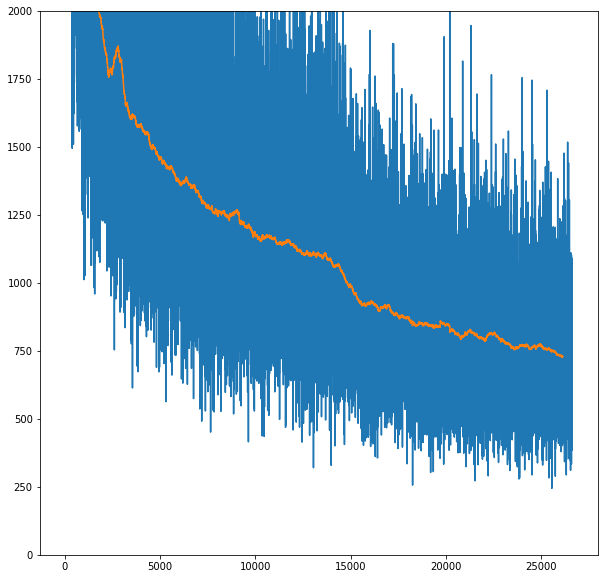

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
def rolling_mean(l, w=500):
    c = np.cumsum(l)
    c[w:] = c[w:] - c[:-w]
    return c[w-1:] / w
    

axes.plot(decoder_losses)
axes.plot(rolling_mean(decoder_losses))
plt.setp(axes, ylim=[0, 2000])

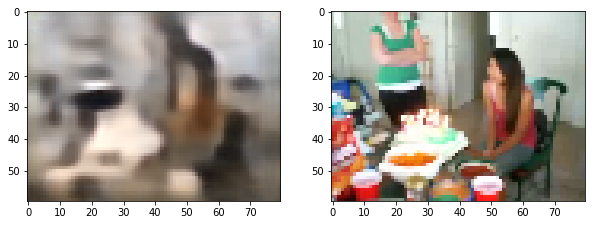

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vid = -2
fid = 3
axes[0].imshow(np.minimum(np.maximum(predictions[vid][0, fid, :, :, :], 0), 255) / 255)
axes[1].imshow(np.minimum(np.maximum(recovery[vid][0, fid+1, :, :, :], 0), 255) / 255)

In [16]:
encodings[-1][0].max()

545.05353

In [17]:
transitions[-1][0].max()

681.30853

In [17]:
from render import render_movie

frame_array = render_movie(recovery[vid][0], 'test_ae_recov2.mp4', 5)

[MoviePy] >>>> Building video test_ae_recov2.mp4
[MoviePy] Writing video test_ae_recov2.mp4


100%|██████████| 64/64 [00:00<00:00, 3044.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_ae_recov2.mp4 

